## Upload two ZIP files:


In [ ]:
  from google.colab import files
  uploaded = files.upload()


Saving Toy Dataset total 377 Images.zip to Toy Dataset total 377 Images.zip


# Extract them to separate folders

In [ ]:
import zipfile

for filename in uploaded.keys():
    foldername = filename.split('.')[0].replace(' ', '_').lower() + "_dataset"
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall(foldername)
    print(f"✅ Extracted {filename} to {foldername}")

✅ Extracted Toy Dataset total 377 Images.zip to toy_dataset_total_377_images_dataset


#Inspect extracted folders

In [ ]:
import os

# Automatically list all *_dataset folders
dataset_folders = [d for d in os.listdir() if d.endswith('_dataset') and os.path.isdir(d)]

for folder in dataset_folders:
    print(f"\n📁 Inspecting: {folder}")
    for root, dirs, files in os.walk(folder):
        print("📂", root)
        for file in files[:5]:
            print("   └──", file)



📁 Inspecting: toy_dataset_total_377_images_dataset
📂 toy_dataset_total_377_images_dataset
📂 toy_dataset_total_377_images_dataset/Toy Dataset total 377 Images
📂 toy_dataset_total_377_images_dataset/Toy Dataset total 377 Images/Testing
📂 toy_dataset_total_377_images_dataset/Toy Dataset total 377 Images/Testing/normal
   └── normal-694.jpg
   └── normal-570.jpg
   └── normal-662.jpg
   └── normal-6.jpg
   └── normal-69.jpg
📂 toy_dataset_total_377_images_dataset/Toy Dataset total 377 Images/Testing/tuberculosis
   └── tuberculosis-104.jpg
   └── tuberculosis-142.jpg
   └── tuberculosis-241.jpg
   └── tuberculosis-255.jpg
   └── tuberculosis-3.jpg
📂 toy_dataset_total_377_images_dataset/Toy Dataset total 377 Images/Testing/pneumonia
   └── pneumonia-94.jpg
   └── person798_virus_1430.jpeg
   └── pneumonia-139.jpg
   └── person783_virus_1414.jpeg
   └── person813_virus_1449.jpeg
📂 toy_dataset_total_377_images_dataset/Toy Dataset total 377 Images/Training
📂 toy_dataset_total_377_images_datase

#Load & Preprocess Dataset

In [ ]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch

# Define image size (Swin-tiny default is 224x224)
IMG_SIZE = 224
BATCH_SIZE = 16

# Define transforms (you can later add augmentations here)
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # for grayscale MRI
])

# Paths
train_dir = 'toy_dataset_total_377_images_dataset/Toy Dataset total 377 Images/Training'
test_dir = 'toy_dataset_total_377_images_dataset/Toy Dataset total 377 Images/Testing'

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Class mapping
class_names = train_dataset.classes
print("✅ Classes:", class_names)


✅ Classes: ['normal', 'pneumonia', 'tuberculosis']


#Visualize Sample Images

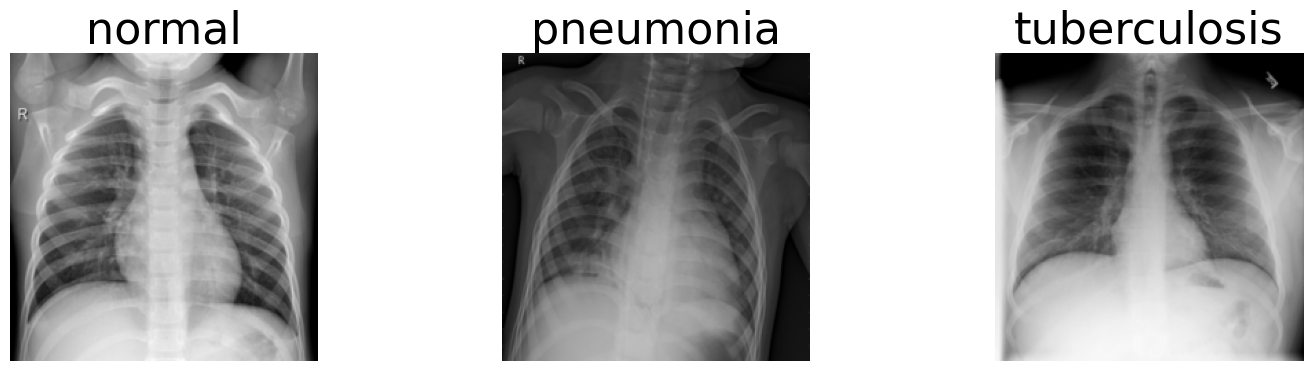

In [ ]:
import torchvision
import matplotlib.pyplot as plt
import numpy as np

def imshow(img, title):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.title(title, fontsize=32)
    plt.axis('off')

# Find the 2nd image per class
examples = {}
counts = {i: 0 for i in range(len(class_names))}  # count images seen per class

for img, label in train_dataset:
    if counts[label] == 2:   # <- 0 means first, 1 means second
        examples[label] = img
    counts[label] += 1
    if len(examples) == len(class_names):
        break

# Prepare images and titles sorted by label index
imgs = [examples[i] for i in range(len(class_names))]
titles = [class_names[i] for i in range(len(class_names))]

# Show images in one grid
plt.figure(figsize=(18, 4))
for i in range(len(class_names)):
    plt.subplot(1, len(class_names), i + 1)
    imshow(imgs[i], titles[i])
plt.show()



#==== > 🔹 Final Setup for your Chest X-ray project <======
		===============================================================================

# Step 1: Model backbone: CoAtNet-0 (or CoAtNet-1/2 if GPU allows) **** [ Hybrid architecture(CoAtNet) = strong feature learning. ]

# Step 2 Training optimizer: SAM (instead of vanilla SGD/Adam) **** [ SAM optimizer = robustness + generalization. ]


# Step 3 Explainability: Grad-CAM (to visualize regions influencing predictions)
## [ Grad-CAM = interpretability (critical in medical imaging).]   


# 1--Install Dependencise ===> for Runing the Deep Learning Algo

In [ ]:
# Colab: install necessary libs
!pip install -q timm grad-cam scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 25.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# 2-- Full Python code (paste into Colab, split into cells if needed)

In [ ]:
# ========== Imports & basic setup ==========
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import timm  # model zoo
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

from sklearn.metrics import confusion_matrix, classification_report

# reproducibility
seed = 42
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


# 3--Paths & dataset ==========

### Short Note
--------------
### Batch size = number of samples the model processes before updating weights once.
### Why 16 here?
###16 is a safe middle ground: Works on most GPUs without running out of memory.

In [ ]:
# ========== Paths & dataset ==========
# Use the paths you already have
train_dir = 'toy_dataset_total_377_images_dataset/Toy Dataset total 377 Images/Training'
test_dir  = 'toy_dataset_total_377_images_dataset/Toy Dataset total 377 Images/Testing'

IMG_SIZE = 224
BATCH_SIZE = 16


# 4---- Create transforms [ CoAtNet ]

## step 1 :  Picked CoAtNet-0 and got its preprocessing config.
## step 2 : Created transform pipelines (train vs test).
## step 3 : Converted chest X-rays (grayscale) into 3-channel normalized tensors.
## step 4 : Built train/test dataloaders with proper augmentation and batching.
## 📌 This means your dataset is now ready to be fed into CoAtNet for training + evaluation.

In [ ]:
# ========== Create transforms (handle grayscale -> 3ch) ==========
# We'll load a small CoAtNet (pretrained on ImageNet) and use its mean/std.
model_name = 'coatnet_0_rw_224'  # It's CoAtNet-0 version of CoTNet

# create a quick model to get data config (no heavy init)
tmp_model = timm.create_model(model_name, pretrained=True, num_classes=1000)
data_config = timm.data.resolve_model_data_config(tmp_model)
print("Data config:", data_config)
del tmp_model  # free memory

# Build transforms: 1) convert grayscale -> 3 channels, 2) resize, 3) normalize with model's mean/std
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),                 # chest X-rays -> 3 channels (replicated)
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=data_config['mean'], std=data_config['std']),
])

test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=data_config['mean'], std=data_config['std']),
])


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/110M [00:00<?, ?B/s]

Data config: {'input_size': (3, 224, 224), 'interpolation': 'bicubic', 'mean': (0.5, 0.5, 0.5), 'std': (0.5, 0.5, 0.5), 'crop_pct': 0.95, 'crop_mode': 'center'}


In [ ]:
# ========== Datasets & Dataloaders ==========
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
test_dataset  = datasets.ImageFolder(test_dir,  transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

class_names = train_dataset.classes
print("Classes:", class_names)
print("Sizes: train", len(train_dataset), "test", len(test_dataset))


Classes: ['normal', 'pneumonia', 'tuberculosis']
Sizes: train 301 test 76


# 5 --📌 This step means: Our CoAtNet is now customized & ready for training on chest X-rays.
## Step 1 : Counted dataset classes → 3.
## Step 2 : Loaded CoAtNet-0 pretrained on ImageNet.
## Step 3 : Replaced final classifier with a 3-class head.
## Step 4 : Sent model to GPU/CPU.
## Step 5 : Printed model to inspect layers for Grad-CAM.

In [ ]:
# ========== Build CoAtNet model (timm) ==========
num_classes = len(class_names)
model = timm.create_model(model_name, pretrained=True, num_classes=num_classes)
model = model.to(device)
print(model)  # inspect to find reasonable target layer for Grad-CAM later (or use automated finder)


MaxxVit(
  (stem): Stem(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (norm1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (stages): Sequential(
    (0): MaxxVitStage(
      (blocks): Sequential(
        (0): MbConvBlock(
          (shortcut): Downsample2d(
            (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
            (expand): Conv2d(64, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          )
          (pre_norm): BatchNormAct2d(
            64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (down): Downsample2d(
            (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
            (expand): Identity

# 6-- SAM optimizer implementation [ SAM(AdamW) ]
## it makes oue training into two Steps
## step 1: Find sharp/worst-case weights (first_step).
## Step 2: Step back and update smoothly (second_step).

## 📌So now your training will use CoAtNet-0 + SAM optimizer instead of plain Adam/SGD.

## Short Note Abut SAM
---------------------------
### --> 	Normally, if you train CoAtNet:
### --> 	We can choose Adam / AdamW / SGD as the optimizer
### -->  	Instead of plain AdamW,  we wrap the base optimizer (SGD/AdamW).

In [ ]:
# =====================================================
# 1. Imports
# =====================================================
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix

# Grad-CAM
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image


# =====================================================
# 2. SAM Optimizer Implementation
# =====================================================
class SAM(torch.optim.Optimizer):
    def __init__(self, params, base_optimizer, rho=0.05, adaptive=False, **kwargs):
        assert rho >= 0.0
        defaults = dict(rho=rho, adaptive=adaptive, **kwargs)
        super(SAM, self).__init__(params, defaults)
        # Base optimizer (AdamW in our case)
        self.base_optimizer = base_optimizer(self.param_groups, **kwargs)

    @torch.no_grad()
    def first_step(self, zero_grad=False):
        grad_norm = self._grad_norm()
        for group in self.param_groups:
            scale = group['rho'] / (grad_norm + 1e-12)
            for p in group['params']:
                if p.grad is None:
                    continue
                if group['adaptive']:
                    e_w = (torch.abs(p) * p.grad) * scale
                else:
                    e_w = p.grad * scale
                p.add_(e_w)
                self.state[p]['e_w'] = e_w
        if zero_grad:
            self.zero_grad()

    @torch.no_grad()
    def second_step(self, zero_grad=False):
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                p.sub_(self.state[p]['e_w'])
        self.base_optimizer.step()
        if zero_grad:
            self.zero_grad()

    def zero_grad(self):
        self.base_optimizer.zero_grad()

    def _grad_norm(self):
        device = self.param_groups[0]['params'][0].device
        norms = []
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                if group['adaptive']:
                    norms.append(((torch.abs(p) * p.grad).norm(2)).to(device))
                else:
                    norms.append((p.grad.norm(2)).to(device))
        if len(norms) == 0:
            return torch.tensor(0.).to(device)
        total_norm = torch.norm(torch.stack(norms), 2.0)
        return total_norm


# =====================================================
# 3. Hyperparameters & Setup
# =====================================================
num_epochs = 10
learning_rate = 1e-4
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# SAM + AdamW optimizer
base_optimizer = torch.optim.AdamW
optimizer = SAM(
    model.parameters(),
    base_optimizer,
    lr=learning_rate,
    weight_decay=weight_decay,
    rho=0.05,
    adaptive=False
)

# LR scheduler (on base optimizer inside SAM)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer.base_optimizer, step_size=7, gamma=0.1)





In [ ]:
# =====================================================
# 4. Training & Evaluation Functions
# =====================================================
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for images, labels in tqdm(loader, desc="Train batches"):
        images, labels = images.to(device), labels.to(device)

        # Step 1
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.first_step(zero_grad=True)

        # Step 2
        outputs2 = model(images)
        loss2 = criterion(outputs2, labels)
        loss2.backward()
        optimizer.second_step(zero_grad=True)

        running_loss += loss2.item() * images.size(0)
        preds = outputs2.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return running_loss / total, correct / total


def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct, total = 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())

    return running_loss / total, correct / total, all_preds, all_labels




In [ ]:
# =====================================================
# 5. Training Loop
# =====================================================
best_acc = 0.0
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc, val_preds, val_labels = evaluate(model, test_loader, criterion, device)

    scheduler.step()

    print(f"Train loss: {train_loss:.4f} acc: {train_acc:.4f} | "
          f"Val loss: {val_loss:.4f} acc: {val_acc:.4f}")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_coatnet_sam.pth")
        print("Saved best model.")





Epoch 1/10


Train batches: 100%|██████████| 19/19 [00:11<00:00,  1.64it/s]


Train loss: 0.9539 acc: 0.5249 | Val loss: 0.7377 acc: 0.6842
Saved best model.

Epoch 2/10


Train batches: 100%|██████████| 19/19 [00:11<00:00,  1.68it/s]


Train loss: 0.7765 acc: 0.6080 | Val loss: 0.5183 acc: 0.7895
Saved best model.

Epoch 3/10


Train batches: 100%|██████████| 19/19 [00:09<00:00,  1.90it/s]


Train loss: 0.5929 acc: 0.7209 | Val loss: 0.5358 acc: 0.7632

Epoch 4/10


Train batches: 100%|██████████| 19/19 [00:09<00:00,  2.02it/s]


Train loss: 0.5466 acc: 0.7276 | Val loss: 0.4405 acc: 0.8289
Saved best model.

Epoch 5/10


Train batches: 100%|██████████| 19/19 [00:11<00:00,  1.61it/s]


Train loss: 0.5202 acc: 0.7475 | Val loss: 0.5402 acc: 0.6842

Epoch 6/10


Train batches: 100%|██████████| 19/19 [00:10<00:00,  1.89it/s]


Train loss: 0.5141 acc: 0.7110 | Val loss: 0.5564 acc: 0.7500

Epoch 7/10


Train batches: 100%|██████████| 19/19 [00:09<00:00,  1.96it/s]


Train loss: 0.5089 acc: 0.7375 | Val loss: 0.4175 acc: 0.7500

Epoch 8/10


Train batches: 100%|██████████| 19/19 [00:09<00:00,  1.91it/s]


Train loss: 0.4368 acc: 0.7542 | Val loss: 0.3795 acc: 0.8289

Epoch 9/10


Train batches: 100%|██████████| 19/19 [00:10<00:00,  1.89it/s]


Train loss: 0.3867 acc: 0.8106 | Val loss: 0.3818 acc: 0.8158

Epoch 10/10


Train batches: 100%|██████████| 19/19 [00:10<00:00,  1.73it/s]


Train loss: 0.3765 acc: 0.8106 | Val loss: 0.3655 acc: 0.8421
Saved best model.


In [ ]:
# =====================================================
# 6. Final Evaluation
# =====================================================
model.load_state_dict(torch.load("best_coatnet_sam.pth", map_location=device))

_, test_acc, preds, labels = evaluate(model, test_loader, criterion, device)

print("Test accuracy:", test_acc)
print(classification_report(labels, preds, target_names=class_names))
print("Confusion matrix:\n", confusion_matrix(labels, preds))




Test accuracy: 0.8421052631578947
              precision    recall  f1-score   support

      normal       0.74      0.74      0.74        23
   pneumonia       0.94      0.97      0.95        31
tuberculosis       0.81      0.77      0.79        22

    accuracy                           0.84        76
   macro avg       0.83      0.83      0.83        76
weighted avg       0.84      0.84      0.84        76

Confusion matrix:
 [[17  2  4]
 [ 1 30  0]
 [ 5  0 17]]


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(labels, preds)

# Plot confusion matrix with accuracy
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix\nTest Accuracy: {test_acc:.2f}%")
plt.show()


# 7--- Train loop using SAM (two-step)
## step 1: First step = climb to sharp region (SAM perturbation).
## Step 2: Second step = update weights toward flat minimum (better generalization).
## Step 3 :Evaluate = check model performance without updating weights.
## Step 4 : Scheduler = adjust LR gradually.
## Step 5 : Checkpointing = keep the best model based on validation accuracy.
## 📌  This step sets up how your CoAtNet-Nano + SAM will learn during training.👉 Without SAM, this loop would only have one forward + one backward + optimizer.step() per batch.
## 👉 With SAM, you do two forwards + two backwards per batch (more expensive, but more robust)

Using target layer: stages.3.blocks.1.mlp.fc2


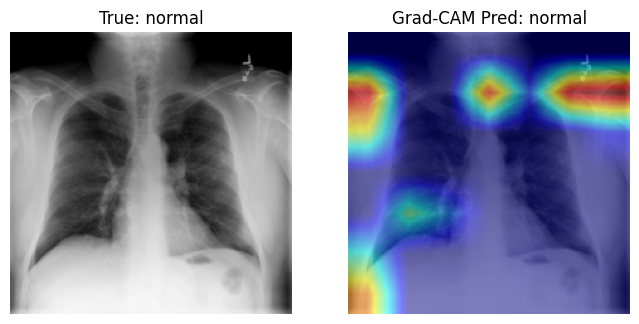

In [ ]:
# =====================================================
# 7. Grad-CAM Visualization
# =====================================================
def unnormalize_tensor(img_tensor, mean, std):
    img = img_tensor.cpu().numpy().transpose(1, 2, 0)
    mean, std = np.array(mean), np.array(std)
    img = (img * std) + mean
    return np.clip(img, 0, 1)

def find_last_conv(model):
    last, last_name = None, None
    for n, m in model.named_modules():
        if isinstance(m, nn.Conv2d):
            last, last_name = m, n
    if last is None:
        raise ValueError("No Conv2d layer found.")
    print("Using target layer:", last_name)
    return last

target_layer = find_last_conv(model)

idx = 5  # pick a test sample
img_tensor, true_label = test_dataset[idx]
inp = img_tensor.unsqueeze(0).to(device)

cam = GradCAM(model=model, target_layers=[target_layer])

model.eval()
with torch.no_grad():
    out = model(inp)
pred_class = int(out.argmax(dim=1).cpu())

targets = [ClassifierOutputTarget(pred_class)]
grayscale_cam = cam(input_tensor=inp, targets=targets)
mask = grayscale_cam[0]

img_for_display = unnormalize_tensor(img_tensor, data_config['mean'], data_config['std'])
cam_image = show_cam_on_image(img_for_display, mask, use_rgb=True)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1); plt.imshow(img_for_display); plt.title(f"True: {class_names[true_label]}"); plt.axis('off')
plt.subplot(1, 2, 2); plt.imshow(cam_image); plt.title(f"Grad-CAM Pred: {class_names[pred_class]}"); plt.axis('off')
plt.show()

# 8. Training Loss & Validation Accuracy Plot


Epoch 1/10


Train batches: 100%|██████████| 19/19 [00:10<00:00,  1.84it/s]


Train loss: 0.3648 acc: 0.8140 | Val loss: 0.3520 acc: 0.8553
Saved best model.

Epoch 2/10


Train batches: 100%|██████████| 19/19 [00:10<00:00,  1.82it/s]


Train loss: 0.3646 acc: 0.8140 | Val loss: 0.3574 acc: 0.8158

Epoch 3/10


Train batches: 100%|██████████| 19/19 [00:10<00:00,  1.84it/s]


Train loss: 0.3400 acc: 0.8106 | Val loss: 0.3280 acc: 0.8684
Saved best model.

Epoch 4/10


Train batches: 100%|██████████| 19/19 [00:10<00:00,  1.87it/s]


Train loss: 0.2991 acc: 0.8405 | Val loss: 0.3390 acc: 0.8553

Epoch 5/10


Train batches: 100%|██████████| 19/19 [00:10<00:00,  1.87it/s]


Train loss: 0.2888 acc: 0.8538 | Val loss: 0.3373 acc: 0.8553

Epoch 6/10


Train batches: 100%|██████████| 19/19 [00:10<00:00,  1.87it/s]


Train loss: 0.2940 acc: 0.8605 | Val loss: 0.3300 acc: 0.8553

Epoch 7/10


Train batches: 100%|██████████| 19/19 [00:10<00:00,  1.89it/s]


Train loss: 0.2924 acc: 0.8605 | Val loss: 0.3437 acc: 0.8421

Epoch 8/10


Train batches: 100%|██████████| 19/19 [00:10<00:00,  1.86it/s]


Train loss: 0.2839 acc: 0.8472 | Val loss: 0.3407 acc: 0.8553

Epoch 9/10


Train batches: 100%|██████████| 19/19 [00:10<00:00,  1.85it/s]


Train loss: 0.2686 acc: 0.8638 | Val loss: 0.3385 acc: 0.8289

Epoch 10/10


Train batches: 100%|██████████| 19/19 [00:10<00:00,  1.88it/s]


Train loss: 0.2723 acc: 0.8505 | Val loss: 0.3284 acc: 0.8684


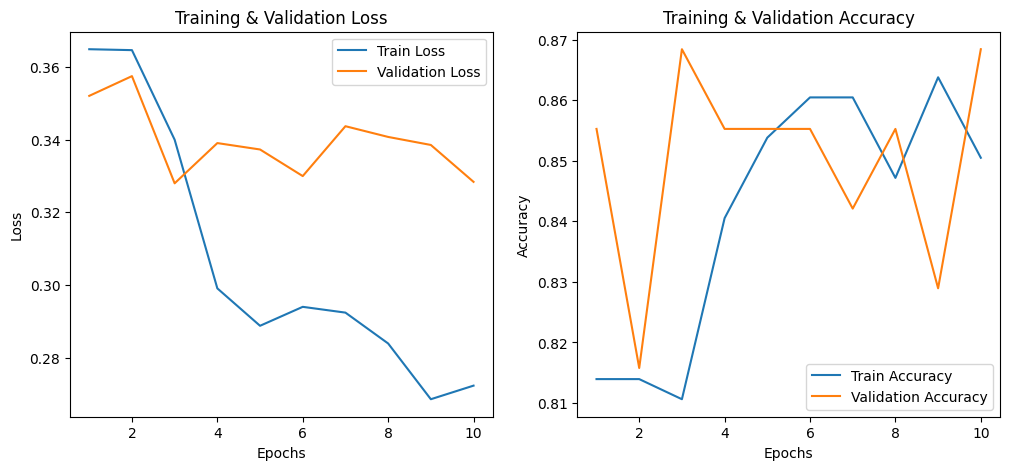

In [ ]:
# =====================================================
# 9. Plot Curves (with Seaborn)
# =====================================================
import seaborn as sns

# Apply seaborn style
sns.set(style="whitegrid", font_scale=1.2)

epochs = range(1, num_epochs+1)

plt.figure(figsize=(14,6))

# Plot Loss
plt.subplot(1,2,1)
sns.lineplot(x=epochs, y=train_losses, label='Train Loss', marker="o")
sns.lineplot(x=epochs, y=val_losses, label='Validation Loss', marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

# Plot Accuracy
plt.subplot(1,2,2)
sns.lineplot(x=epochs, y=train_accs, label='Train Accuracy', marker="o")
sns.lineplot(x=epochs, y=val_accs, label='Validation Accuracy', marker="o")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


# 9-🔹 Loss Curve Code for CoAtNet-0 + SAM + AdamW
# loss Curve of Mmodel

In [ ]:
# =====================================================
# Track losses & accuracies
# =====================================================
train_losses = []
val_losses = []
train_accs = []
val_accs = []

best_acc = 0.0
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc, val_preds, val_labels = evaluate(model, test_loader, criterion, device)

    scheduler.step()

    # Save history
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Train loss: {train_loss:.4f} acc: {train_acc:.4f} | "
          f"Val loss: {val_loss:.4f} acc: {val_acc:.4f}")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_coatnet_sam.pth")
        print("Saved best model.")



Epoch 1/10


Train batches: 100%|██████████| 19/19 [00:10<00:00,  1.82it/s]


Train loss: 0.2796 acc: 0.8638 | Val loss: 0.3217 acc: 0.8816
Saved best model.

Epoch 2/10


Train batches: 100%|██████████| 19/19 [00:11<00:00,  1.67it/s]


Train loss: 0.2557 acc: 0.8638 | Val loss: 0.3301 acc: 0.8553

Epoch 3/10


Train batches: 100%|██████████| 19/19 [00:10<00:00,  1.81it/s]


Train loss: 0.2657 acc: 0.8538 | Val loss: 0.3385 acc: 0.8421

Epoch 4/10


Train batches: 100%|██████████| 19/19 [00:10<00:00,  1.84it/s]


Train loss: 0.2816 acc: 0.8671 | Val loss: 0.3403 acc: 0.8421

Epoch 5/10


Train batches: 100%|██████████| 19/19 [00:10<00:00,  1.86it/s]


Train loss: 0.2649 acc: 0.8738 | Val loss: 0.3278 acc: 0.8421

Epoch 6/10


Train batches: 100%|██████████| 19/19 [00:10<00:00,  1.84it/s]


Train loss: 0.2805 acc: 0.8538 | Val loss: 0.3357 acc: 0.8421

Epoch 7/10


Train batches: 100%|██████████| 19/19 [00:10<00:00,  1.86it/s]


Train loss: 0.2861 acc: 0.8704 | Val loss: 0.3373 acc: 0.8816

Epoch 8/10


Train batches: 100%|██████████| 19/19 [00:10<00:00,  1.81it/s]


Train loss: 0.2833 acc: 0.8638 | Val loss: 0.3244 acc: 0.8816

Epoch 9/10


Train batches: 100%|██████████| 19/19 [00:11<00:00,  1.68it/s]


Train loss: 0.2584 acc: 0.8804 | Val loss: 0.3382 acc: 0.8684

Epoch 10/10


Train batches: 100%|██████████| 19/19 [00:10<00:00,  1.85it/s]


Train loss: 0.2754 acc: 0.8671 | Val loss: 0.3274 acc: 0.8816


## You’ll see a clean loss curve (Train vs Validation) across epochs, which will help check:

## If train loss decreases smoothly (optimizer working well).

## If validation loss plateaus/diverges (signs of overfitting).

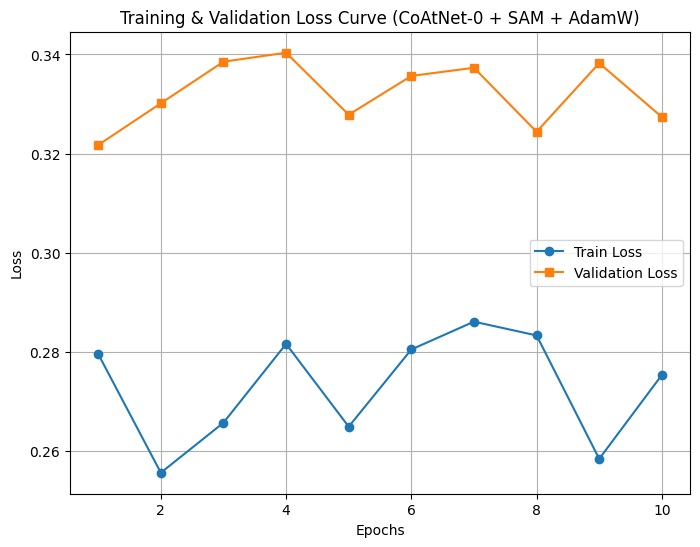

In [ ]:
# =====================================================
# Plot Loss Curve
# =====================================================
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss', marker='s')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss Curve (CoAtNet-0 + SAM + AdamW)")
plt.legend()
plt.grid(True)
plt.show()
